In [59]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
from pandas.io.json import json_normalize

from collections import Counter
import itertools

a4_dims = (11.7, 8.27)
windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']

In [89]:
def get_df(json_file):
    x = json.load(open(json_file))
    x = pd.DataFrame(x['views'])
    #x = x.drop(['_id'],axis=1)
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    return x

def prepare_file(fname):
    startOfFile = "{\"views\":["
    endOfFile = "]}"
    with open(fname,'r') as f:
        data = f.readlines()
        f.close()
    with open("degree/tmp.json",'w') as tmp:
        tmp.write(startOfFile+data.pop(0).strip()+",\n")
        while len(data)>1:
            tmp.write(data.pop(0).strip()+",\n")
        tmp.write(data.pop(0).strip()+endOfFile)
        tmp.close()

def prepare_degree_file(fname):
    windows.reverse()
    startOfFile = "{\"views\":["
    endOfFile = "}]}"
    with open(fname,'r') as f:
        data = f.readlines()
        f.close()
    with open("degree/tmp.json",'w') as tmp:
        i = 0
        tmp.write(startOfFile+data.pop(0).strip().strip("}")+",\"windowsize\":"+str(windows[i%4])+"},\n")
        i+=1
        while len(data)>1:
            tmp.write(data.pop(0).strip().strip("}")+",\"windowsize\":"+str(windows[i%4])+"},\n")
            i+=1
        tmp.write(data.pop(0).strip().strip("}")+",\"windowsize\":"+str(windows[i%4])+endOfFile)
        tmp.close()

# Weighted Page Rank Results

In [69]:
def get_rank(rankings, user):
    rank = 10
    for row in rankings:
        if row['id']==user:
            return rank
        rank-=1
    return rank

def get_pagerank(rankings, user):
    for row in rankings:
        if row['id']==user:
            return row['pagerank']
    return None

def get_trajectory(user, pr):
    traj = np.asarray(list(pr['bestusers'].apply(lambda row: get_rank(row,user))))
    return traj

def get_pr_trajectory(user,pr):
    traj = np.asarray(list(pr['bestusers'].apply(lambda row: get_pagerank(row,user))))
    return traj

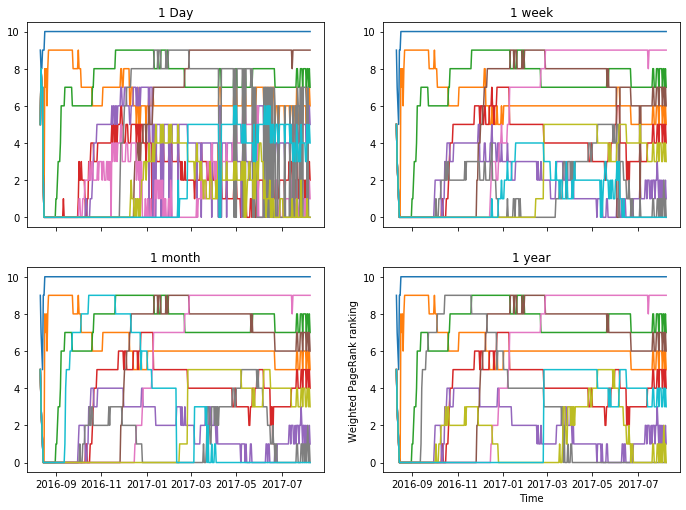

In [39]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=a4_dims, sharex=True)

file = "degree/WeightedPageRank.json"
pagerank = get_df(file).iloc[108:]

windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']

for i, ax in enumerate(axes.flatten()):
    window = windows[i]
    name = window_names[i]
    pr = pagerank[pagerank['windowsize']==window]
    times = np.asarray(pr['time'])
    all_users = list(itertools.chain.from_iterable(pr['bestusers'].tolist()))
    unique_users = list(map(lambda y:y[0],Counter(list(map(lambda row: row['id'], all_users))).most_common(10)))
    for user in list(unique_users):
        ax.plot(times,get_trajectory(user,pr),label="User "+str(user))
    ax.set_title(name)
    
plt.xlabel('Time')
plt.ylabel('Weighted PageRank ranking')
plt.show()

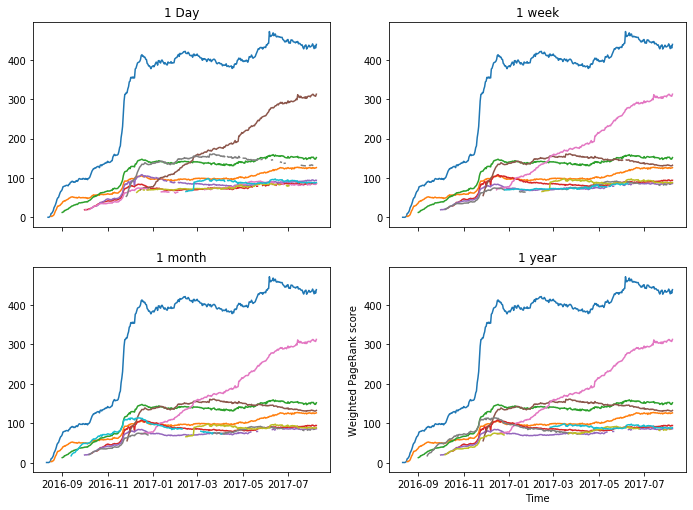

In [70]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=a4_dims, sharex=True)

file = "degree/WeightedPageRank.json"
pagerank = get_df(file).iloc[108:]

windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']

for i, ax in enumerate(axes.flatten()):
    window = windows[i]
    name = window_names[i]
    pr = pagerank[pagerank['windowsize']==window]
    times = np.asarray(pr['time'])
    all_users = list(itertools.chain.from_iterable(pr['bestusers'].tolist()))
    unique_users = list(map(lambda y:y[0],Counter(list(map(lambda row: row['id'], all_users))).most_common(10)))
    for user in list(unique_users):
        ax.plot(times,get_pr_trajectory(user,pr),label="User "+str(user))
    ax.set_title(name)
    
plt.xlabel('Time')
plt.ylabel('Weighted PageRank score')
plt.show()

# Degree Distribution Results -- under construction

,avgSquaredDeg,avgSquaredInDeg,avgSquaredOutDeg,maxDeg,time,vertices,viewTime,windowsize,index
3,0.0,0.0,0.0,0,2016-08-09 23:00:00,0,128149,86400000,2016-08-09 23:00:00
7,8.0,1.0,3.0,6,2016-08-10 23:00:00,5,76904,86400000,2016-08-10 23:00:00
11,1.0,0.0,0.0,1,2016-08-11 23:00:00,2,64,86400000,2016-08-11 23:00:00
15,19.0,3.0,7.0,7,2016-08-12 23:00:00,3,280,86400000,2016-08-12 23:00:00
19,22.0,5.0,5.0,8,2016-08-13 23:00:00,3,1242,86400000,2016-08-13 23:00:00
23,29.0,6.0,9.0,12,2016-08-14 23:00:00,8,515,86400000,2016-08-14 23:00:00
27,47.0,11.0,13.0,25,2016-08-15 23:00:00,16,571,86400000,2016-08-15 23:00:00
31,138.0,36.0,35.0,72,2016-08-16 23:00:00,61,69,86400000,2016-08-16 23:00:00
35,293.0,74.0,77.0,95,2016-08-17 23:00:00,56,1333,86400000,2016-08-17 23:00:00
39,438.0,112.0,114.0,127,2016-08-18 23:00:00,66,297,86400000,2016-08-18 23:00:00


,avgSquaredDeg,avgSquaredInDeg,avgSquaredOutDeg,maxDeg,time,vertices,viewTime,windowsize,index
2,0.0,0.0,0.0,0,2016-08-09 23:00:00,0,128149,604800000,2016-08-09 23:00:00
6,8.0,1.0,3.0,6,2016-08-10 23:00:00,5,76904,604800000,2016-08-10 23:00:00
10,6.0,1.0,2.0,6,2016-08-11 23:00:00,7,64,604800000,2016-08-11 23:00:00
14,8.0,1.0,2.0,7,2016-08-12 23:00:00,8,280,604800000,2016-08-12 23:00:00
18,9.0,2.0,2.0,8,2016-08-13 23:00:00,9,1242,604800000,2016-08-13 23:00:00
22,19.0,4.0,6.0,12,2016-08-14 23:00:00,12,515,604800000,2016-08-14 23:00:00
26,34.0,8.0,9.0,25,2016-08-15 23:00:00,22,571,604800000,2016-08-15 23:00:00
30,126.0,33.0,32.0,72,2016-08-16 23:00:00,67,69,604800000,2016-08-16 23:00:00
34,189.0,49.0,49.0,95,2016-08-17 23:00:00,91,1333,604800000,2016-08-17 23:00:00
38,260.0,67.0,68.0,127,2016-08-18 23:00:00,114,297,604800000,2016-08-18 23:00:00


,avgSquaredDeg,avgSquaredInDeg,avgSquaredOutDeg,maxDeg,time,vertices,viewTime,windowsize,index
1,0.0,0.0,0.0,0,2016-08-09 23:00:00,0,128149,2592000000,2016-08-09 23:00:00
5,8.0,1.0,3.0,6,2016-08-10 23:00:00,5,76904,2592000000,2016-08-10 23:00:00
9,6.0,1.0,2.0,6,2016-08-11 23:00:00,7,64,2592000000,2016-08-11 23:00:00
13,8.0,1.0,2.0,7,2016-08-12 23:00:00,8,280,2592000000,2016-08-12 23:00:00
17,9.0,2.0,2.0,8,2016-08-13 23:00:00,9,1242,2592000000,2016-08-13 23:00:00
21,19.0,4.0,6.0,12,2016-08-14 23:00:00,12,515,2592000000,2016-08-14 23:00:00
25,34.0,8.0,9.0,25,2016-08-15 23:00:00,22,571,2592000000,2016-08-15 23:00:00
29,126.0,33.0,32.0,72,2016-08-16 23:00:00,67,69,2592000000,2016-08-16 23:00:00
33,187.0,48.0,49.0,95,2016-08-17 23:00:00,92,1333,2592000000,2016-08-17 23:00:00
37,255.0,66.0,67.0,127,2016-08-18 23:00:00,116,297,2592000000,2016-08-18 23:00:00


,avgSquaredDeg,avgSquaredInDeg,avgSquaredOutDeg,maxDeg,time,vertices,viewTime,windowsize,index
0,0.0,0.0,0.0,0,2016-08-09 23:00:00,0,128149,31536000000,2016-08-09 23:00:00
4,8.0,1.0,3.0,6,2016-08-10 23:00:00,5,76904,31536000000,2016-08-10 23:00:00
8,6.0,1.0,2.0,6,2016-08-11 23:00:00,7,64,31536000000,2016-08-11 23:00:00
12,8.0,1.0,2.0,7,2016-08-12 23:00:00,8,280,31536000000,2016-08-12 23:00:00
16,9.0,2.0,2.0,8,2016-08-13 23:00:00,9,1242,31536000000,2016-08-13 23:00:00
20,19.0,4.0,6.0,12,2016-08-14 23:00:00,12,515,31536000000,2016-08-14 23:00:00
24,34.0,8.0,9.0,25,2016-08-15 23:00:00,22,571,31536000000,2016-08-15 23:00:00
28,126.0,33.0,32.0,72,2016-08-16 23:00:00,67,69,31536000000,2016-08-16 23:00:00
32,187.0,48.0,49.0,95,2016-08-17 23:00:00,92,1333,31536000000,2016-08-17 23:00:00
36,255.0,66.0,67.0,127,2016-08-18 23:00:00,116,297,31536000000,2016-08-18 23:00:00


,avgSquaredDeg,avgSquaredInDeg,avgSquaredOutDeg,maxDeg,time,vertices,viewTime,windowsize,index
3,0.0,0.0,0.0,0,2016-08-09 23:00:00,0,128149,86400000,2016-08-09 23:00:00
7,8.0,1.0,3.0,6,2016-08-10 23:00:00,5,76904,86400000,2016-08-10 23:00:00
11,1.0,0.0,0.0,1,2016-08-11 23:00:00,2,64,86400000,2016-08-11 23:00:00
15,19.0,3.0,7.0,7,2016-08-12 23:00:00,3,280,86400000,2016-08-12 23:00:00
19,22.0,5.0,5.0,8,2016-08-13 23:00:00,3,1242,86400000,2016-08-13 23:00:00
23,29.0,6.0,9.0,12,2016-08-14 23:00:00,8,515,86400000,2016-08-14 23:00:00
27,47.0,11.0,13.0,25,2016-08-15 23:00:00,16,571,86400000,2016-08-15 23:00:00
31,138.0,36.0,35.0,72,2016-08-16 23:00:00,61,69,86400000,2016-08-16 23:00:00
35,293.0,74.0,77.0,95,2016-08-17 23:00:00,56,1333,86400000,2016-08-17 23:00:00
39,438.0,112.0,114.0,127,2016-08-18 23:00:00,66,297,86400000,2016-08-18 23:00:00


,avgSquaredDeg,avgSquaredInDeg,avgSquaredOutDeg,maxDeg,time,vertices,viewTime,windowsize,index
2,0.0,0.0,0.0,0,2016-08-09 23:00:00,0,128149,604800000,2016-08-09 23:00:00
6,8.0,1.0,3.0,6,2016-08-10 23:00:00,5,76904,604800000,2016-08-10 23:00:00
10,6.0,1.0,2.0,6,2016-08-11 23:00:00,7,64,604800000,2016-08-11 23:00:00
14,8.0,1.0,2.0,7,2016-08-12 23:00:00,8,280,604800000,2016-08-12 23:00:00
18,9.0,2.0,2.0,8,2016-08-13 23:00:00,9,1242,604800000,2016-08-13 23:00:00
22,19.0,4.0,6.0,12,2016-08-14 23:00:00,12,515,604800000,2016-08-14 23:00:00
26,34.0,8.0,9.0,25,2016-08-15 23:00:00,22,571,604800000,2016-08-15 23:00:00
30,126.0,33.0,32.0,72,2016-08-16 23:00:00,67,69,604800000,2016-08-16 23:00:00
34,189.0,49.0,49.0,95,2016-08-17 23:00:00,91,1333,604800000,2016-08-17 23:00:00
38,260.0,67.0,68.0,127,2016-08-18 23:00:00,114,297,604800000,2016-08-18 23:00:00


,avgSquaredDeg,avgSquaredInDeg,avgSquaredOutDeg,maxDeg,time,vertices,viewTime,windowsize,index
1,0.0,0.0,0.0,0,2016-08-09 23:00:00,0,128149,2592000000,2016-08-09 23:00:00
5,8.0,1.0,3.0,6,2016-08-10 23:00:00,5,76904,2592000000,2016-08-10 23:00:00
9,6.0,1.0,2.0,6,2016-08-11 23:00:00,7,64,2592000000,2016-08-11 23:00:00
13,8.0,1.0,2.0,7,2016-08-12 23:00:00,8,280,2592000000,2016-08-12 23:00:00
17,9.0,2.0,2.0,8,2016-08-13 23:00:00,9,1242,2592000000,2016-08-13 23:00:00
21,19.0,4.0,6.0,12,2016-08-14 23:00:00,12,515,2592000000,2016-08-14 23:00:00
25,34.0,8.0,9.0,25,2016-08-15 23:00:00,22,571,2592000000,2016-08-15 23:00:00
29,126.0,33.0,32.0,72,2016-08-16 23:00:00,67,69,2592000000,2016-08-16 23:00:00
33,187.0,48.0,49.0,95,2016-08-17 23:00:00,92,1333,2592000000,2016-08-17 23:00:00
37,255.0,66.0,67.0,127,2016-08-18 23:00:00,116,297,2592000000,2016-08-18 23:00:00


,avgSquaredDeg,avgSquaredInDeg,avgSquaredOutDeg,maxDeg,time,vertices,viewTime,windowsize,index
0,0.0,0.0,0.0,0,2016-08-09 23:00:00,0,128149,31536000000,2016-08-09 23:00:00
4,8.0,1.0,3.0,6,2016-08-10 23:00:00,5,76904,31536000000,2016-08-10 23:00:00
8,6.0,1.0,2.0,6,2016-08-11 23:00:00,7,64,31536000000,2016-08-11 23:00:00
12,8.0,1.0,2.0,7,2016-08-12 23:00:00,8,280,31536000000,2016-08-12 23:00:00
16,9.0,2.0,2.0,8,2016-08-13 23:00:00,9,1242,31536000000,2016-08-13 23:00:00
20,19.0,4.0,6.0,12,2016-08-14 23:00:00,12,515,31536000000,2016-08-14 23:00:00
24,34.0,8.0,9.0,25,2016-08-15 23:00:00,22,571,31536000000,2016-08-15 23:00:00
28,126.0,33.0,32.0,72,2016-08-16 23:00:00,67,69,31536000000,2016-08-16 23:00:00
32,187.0,48.0,49.0,95,2016-08-17 23:00:00,92,1333,31536000000,2016-08-17 23:00:00
36,255.0,66.0,67.0,127,2016-08-18 23:00:00,116,297,31536000000,2016-08-18 23:00:00


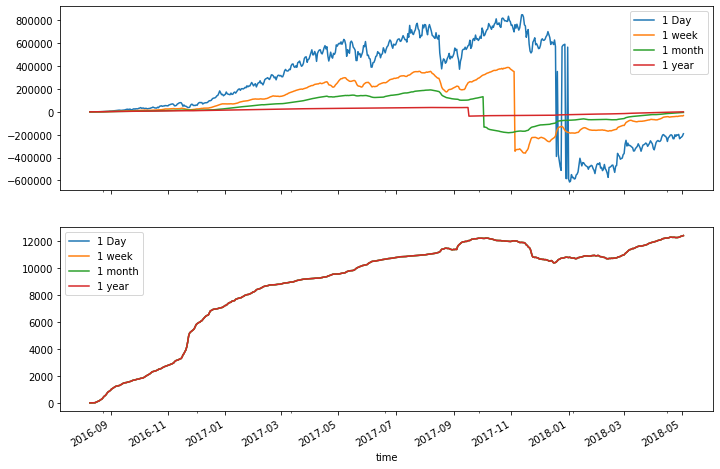

In [68]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=a4_dims, sharex=True)

file = "degree/DegreeDistribution.json"
prepare_file(file)
degdf = get_df("degree/tmp.json")

windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']
toPlot = ['avgSquaredDeg','maxDeg']
names = ['Average Squared Degree', 'Maximum Degree']

for i, ax in enumerate(axes.flatten()):
    for j, w in enumerate(windows):
        deg = degdf[degdf['windowsize']==w]
        display(deg)
        deg.plot(x='time',y=toPlot[i], ax=ax, label = window_names[j])
    ax.legend()

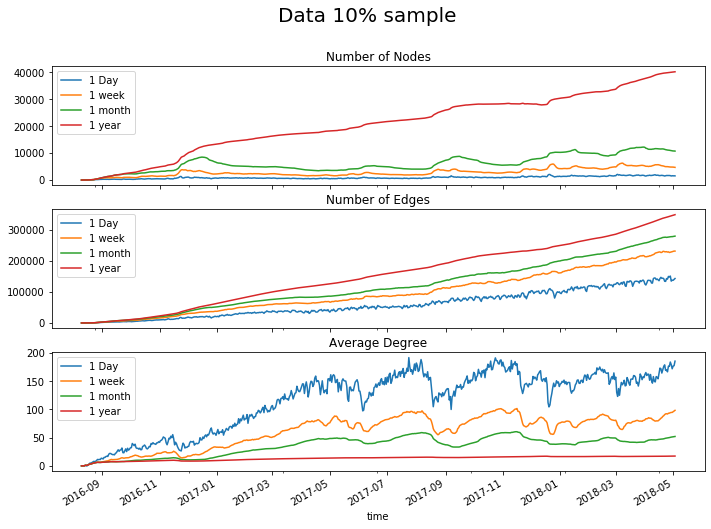

In [108]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=a4_dims, sharex=True)

file = "degree/DegBasic0.1.json"
prepare_file(file)
degdf = get_df("degree/tmp.json")

windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']
toPlot = ['vertices','edges','avgdeg']
names = ['Number of Nodes', 'Number of Edges', 'Average Degree']

fig.suptitle('Data 10% sample',fontsize=20)

for i, ax in enumerate(axes.flatten()):
    for j, w in enumerate(windows):
        deg = degdf[degdf['windowsize']==w]
        deg['avgdeg'] = np.where(deg['vertices']>0,2*deg['edges']/deg['vertices'],0)
        deg.plot(x='time',y=toPlot[i], ax=ax, label = window_names[j])
    ax.set_title(names[i])
    #ax.set_yscale('log')
    ax.legend()
    
plt.show()

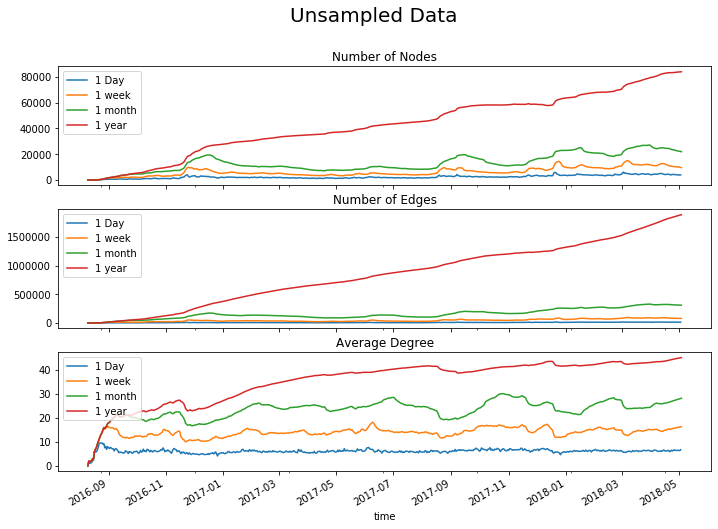

In [110]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=a4_dims, sharex=True)

file = "degree/degreewindows.json"
degdf = get_df(file)

windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']
toPlot = ['vertices','edges','avgdeg']
names = ['Number of Nodes', 'Number of Edges', 'Average Degree']

for i, ax in enumerate(axes.flatten()):
    for j, w in enumerate(windows):
        deg = degdf[degdf['windowsize']==w]
        deg['avgdeg'] = np.where(deg['vertices']>0,2*deg['edges']/deg['vertices'],0)
        deg.plot(x='time',y=toPlot[i], ax=ax, label = window_names[j])
    ax.set_title(names[i])
    #ax.set_yscale('log')
    ax.legend()
    
fig.suptitle('Unsampled Data',fontsize=20)
plt.show()